<a href="https://colab.research.google.com/github/Group2-P6-Bachelor-Project/Model/blob/main/P6_Bachelor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting and Importing packages

In [ ]:
import tensorflow as tf
print(tf.__version__)
!pip install pyunpack
!pip install patool
!pip install tf-nightly
import tensorflow as tf
print(tf.__version__)

2.14.0-dev20230520
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.14.0-dev20230520


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
from pyunpack import Archive
import pathlib
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import os
# import shutil

# # Set the paths to the three folders
# dataset_folders = ['/content/my_dataset/InitialV2', '/content/my_validationset2/ValidationSet', '/content/validationset_wastepictures/Validation_WastePicture']

# # Create a new folder to store the merged files
# merged_folder = '/content/collectedDataSet123'
# if not os.path.exists(merged_folder):
#     os.mkdir(merged_folder)

# # Iterate over each subfolder in the dataset folders and move the images to the corresponding subfolder in the merged folder
# for subfolder_name in os.listdir(dataset_folders[0]):
#     subfolder_path = os.path.join(merged_folder, subfolder_name)
#     os.makedirs(subfolder_path, exist_ok=True)  # Create the subfolder if it doesn't already exist
#     for dataset_folder in dataset_folders:
#         src_path = os.path.join(dataset_folder, subfolder_name)
#         for file_name in os.listdir(src_path):
#             src_file_path = os.path.join(src_path, file_name)
#             dst_file_path = os.path.join(subfolder_path, file_name)
#             shutil.copy(src_file_path, dst_file_path)  # Copy the file to the merged folder

In [ ]:
!mkdir training_dataset
Archive('/content/gdrive/MyDrive/InitialV2.rar').extractall('/content/training_dataset')

!mkdir validationSet1
Archive('/content/gdrive/MyDrive/ValidationSet.rar').extractall('/content/validationSet1')

!mkdir validationSet2
Archive('/content/gdrive/MyDrive/Validation_WastePicture.zip').extractall('/content/validationSet2')

data_dir = pathlib.Path('/content/training_dataset/InitialV2')
val_dir = pathlib.Path('/content/validationSet1/ValidationSet')
val_dir2 = pathlib.Path('/content/validationSet2/Validation_WastePicture')

mkdir: cannot create directory ‘training_dataset’: File exists
mkdir: cannot create directory ‘validationSet1’: File exists
mkdir: cannot create directory ‘validationSet2’: File exists




# Training

In [ ]:
train_accs = []
val_accs = []
loss = []
img_size = (260, 260)
batch_size = 32
seeds = [1234551]
val_loss = []
dir_paths = [data_dir, val_dir, val_dir2]
for seed in seeds:
  
  train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      directory=data_dir,
      validation_split=0.2,
      subset= 'both',
      seed=seed,
      image_size=img_size,
      batch_size=batch_size)

  data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ])

  train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
  label_names = sorted(item.name for item in data_dir.glob('*/') if item.is_dir())
  label_encoder = tf.keras.layers.experimental.preprocessing.StringLookup()
  label_encoder.adapt(label_names)

  # Map the labels to integers
  train_labels = train_ds.map(lambda x, y: label_encoder(y))
  val_labels = val_ds.map(lambda x, y: label_encoder(y))

  num_classes = len(label_encoder.get_vocabulary())

  base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_shape=(260, 260, 3))
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(260, 260, 3))
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)\
  
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10)
  train_accs.append(history.history['accuracy'][-1])
  val_accs.append(history.history['val_accuracy'][-1])
  loss.append(history.history['loss'][-1])
  val_loss.append(history.history['val_loss'][-1])
for i in range(len(seeds)):
    print(f'Seed {seeds[i]}: Train accuracy = {train_accs[i]}, Validation accuracy = {val_accs[i]}, Loss = {loss[i]}, Validation Loss = {val_loss[i]}')

Found 2945 files belonging to 6 classes.
Using 2356 files for training.
Using 589 files for validation.
31790344/31790344 [==============================] - 1s 0us/step
Epoch 1/10
74/74 [==============================] - 84s 845ms/step - loss: 0.9476 - accuracy: 0.6969 - val_loss: 0.5369 - val_accuracy: 0.8591
Epoch 2/10
74/74 [==============================] - 71s 901ms/step - loss: 0.4766 - accuracy: 0.8587 - val_loss: 0.4095 - val_accuracy: 0.8846
Epoch 3/10
74/74 [==============================] - 62s 813ms/step - loss: 0.3821 - accuracy: 0.8773 - val_loss: 0.3597 - val_accuracy: 0.8998
Epoch 4/10
74/74 [==============================] - 57s 734ms/step - loss: 0.3239 - accuracy: 0.9011 - val_loss: 0.3295 - val_accuracy: 0.9049
Epoch 5/10
74/74 [==============================] - 55s 718ms/step - loss: 0.2937 - accuracy: 0.9075 - val_loss: 0.3100 - val_accuracy: 0.9032
Epoch 6/10
74/74 [==============================] - 60s 790ms/step - loss: 0.2677 - accuracy: 0.9181 - val_loss: 0.3

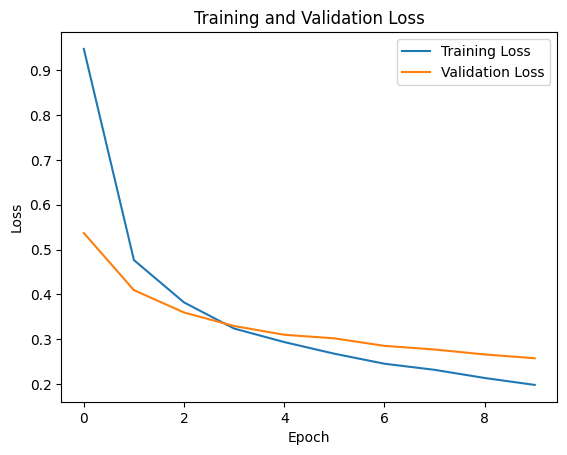

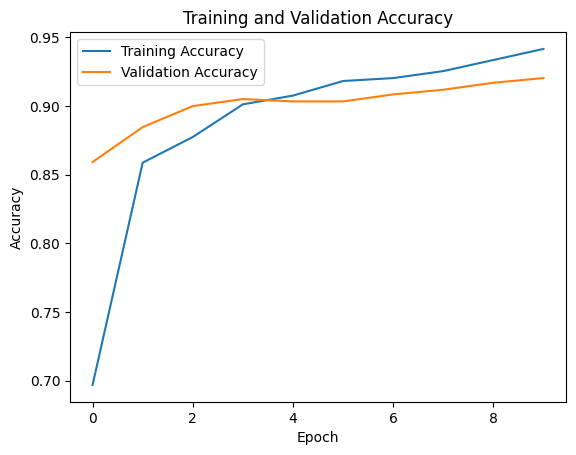

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Confusion Matrix

In [ ]:
test_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      directory=val_dir,
      validation_split=None,
      subset= None,
      seed=1234551,
      image_size=img_size,
      batch_size=1)

Found 120 files belonging to 6 classes.


19/19 [==============================] - 12s 616ms/step


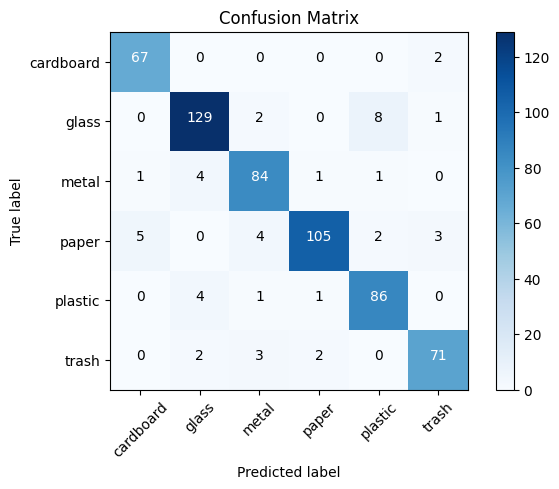

In [ ]:
#Confusion Matrix

# Get the true labels and predicted labels
y_true = np.concatenate([y for x, y in test_val_ds], axis=0)
y_pred = np.argmax(model.predict(test_val_ds), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_val_ds.class_names))
plt.xticks(tick_marks, test_val_ds.class_names, rotation=45)
plt.yticks(tick_marks, test_val_ds.class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plotting images that were misclassified

In [ ]:
def plot_misclassified_images(val_test_ds, y_true, y_pred, model):
    for i, (image, label) in enumerate(val_test_ds.unbatch()):
        if y_true[i] != y_pred[i]:
            # Get the predicted class probabilities
            probs = model.predict(np.expand_dims(image, axis=0))[0]
            pred_class_prob = probs[y_pred[i]]
            
            # Plot the image and mislabeled class information
            plt.figure(figsize=(4,4))
            plt.imshow(image.numpy().astype(np.uint8))
            plt.title(f'True label: {val_test_ds.class_names[y_true[i]]}, Predicted label: {val_test_ds.class_names[y_pred[i]]}, Confidence: {pred_class_prob:.2f}')
            plt.axis('off')
            plt.show()
plot_misclassified_images(val_ds, y_true, y_pred, model)

# Merging datasets to check the threshold


In [ ]:
import os
import shutil

# Set the paths to the three folders
dataset_folders = ['/content/validationSet1/ValidationSet', '/content/validationSet2/Validation_WastePicture']

# Create a new folder to store the merged files
merged_folder = '/content/thresholdDataSet'
if not os.path.exists(merged_folder):
    os.mkdir(merged_folder)

# Iterate over each subfolder in the dataset folders and move the images to the corresponding subfolder in the merged folder
for subfolder_name in os.listdir(dataset_folders[0]):
    subfolder_path = os.path.join(merged_folder, subfolder_name)
    os.makedirs(subfolder_path, exist_ok=True)  # Create the subfolder if it doesn't already exist
    for dataset_folder in dataset_folders:
        src_path = os.path.join(dataset_folder, subfolder_name)
        for file_name in os.listdir(src_path):
            src_file_path = os.path.join(src_path, file_name)
            dst_file_path = os.path.join(subfolder_path, file_name)
            shutil.copy(src_file_path, dst_file_path)  # Copy the file to the merged folder

In [ ]:
threshold_ds = tf.keras.preprocessing.image_dataset_from_directory(
      directory=merged_folder,
      validation_split=None,
      subset= None,
      seed=1234551,
      image_size=img_size,
      batch_size=16)

Found 1139 files belonging to 6 classes.


In [ ]:
x_test = []
y_test = []
for images, labels in threshold_ds:
    x_test.append(images)
    y_test.append(labels)

x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

In [ ]:
threshold_model = tf.keras.models.load_model('threshold_model.h5')

# Looking at the threshold

In [ ]:
def accuracy_by_treshold(model, x, labels, threshold):
  probs=model(x).numpy()
  above_threshold = np.max(probs,axis=1)>threshold
  correct = np.argmax(probs, axis=1) == np.squeeze(labels)
  return threshold, 100*np.sum(np.logical_and(above_threshold, correct))/np.sum(above_threshold), 100*np.sum(above_threshold)/x.shape[0]

def plot_accuracy_by_treshold(model, x, labels):
  values = np.array([accuracy_by_treshold(model, x, labels, threshold) for threshold in np.arange(0.0,1,0.01)])
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(values[:,0],values[:,1], 'g-')
  ax2.plot(values[:,0],values[:,2], 'b-')

  ax1.set_xlabel('Decision Threshold')
  ax1.set_ylabel('Accuracy', color='g')
  ax2.set_ylabel('Coverage', color='b')

  plt.show()

  return np.mean(values[:,1]), np.mean(values[:,2]) 

In [ ]:
# MNIST:  Plot Accuracy / Coverage evolution for different thresholds
area_acc, area_coverage = plot_accuracy_by_treshold(threshold_model, x_test, y_test)
print('Area under Accuracy on MNIST test set: ',
      str(area_acc))
print('Area under Coverage on MNIST test set: ',
      str(area_coverage))

ResourceExhaustedError: ignored

# Converting the keras model to a tflite one.

In [ ]:
tflite_output_path = '/content/converted_model.tflite'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

with open(tflite_output_path, 'wb') as f:
    f.write(tflite_model)

NameError: ignored

# Testing tflite model

In [ ]:
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
from PIL import Image

image = tf.keras.preprocessing.image.load_img('/content/IMG_0947.jpg', target_size=(260, 260))

# Apply the data augmentation to the input image
# image = data_augmentation(np.array(image))


image = np.array(image, dtype=np.float32)


image = tf.keras.applications.efficientnet.preprocess_input(image)
image = np.expand_dims(image, 0)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_labels = np.argmax(output_data, axis=1)[0]

In [ ]:
# Display the image and the predicted labels
plt.imshow(image[0])
plt.title("Predicted label: {}".format(class_names[predicted_labels]))
plt.show()

# Print the predicted probabilities for all labels
for i in range(len(class_names)):
    print("{}: {:.2f}%".format(class_names[i], output_data[0][i] * 100))

# Validation with different datasets

In [ ]:
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      val_dir,
      image_size=img_size,
      validation_split=0,
      batch_size=batch_size,
      shuffle=False)

Confusion Matrix

In [ ]:

# Get the true labels and predicted labels
y_test_true = np.concatenate([y for x, y in val_test_ds], axis=0)
y_test_pred = np.argmax(model.predict(val_test_ds), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_test_ds.class_names))
plt.xticks(tick_marks, val_test_ds.class_names, rotation=45)
plt.yticks(tick_marks, val_test_ds.class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
plot_threshold(val_ds, new_model)

In [ ]:
plot_misclassified_images(val_test_ds, y_test_true, y_test_pred, new_model)

Ensembling

In [ ]:
# model1 = tf.keras.models.load_model('model2.h5')
# model2 = tf.keras.models.load_model('model4.h5')
# model3 = tf.keras.models.load_model('model5.h5')

In [ ]:
# model1._name = 'epoch30model'
# model2._name = 'epoch10model'
# model3._name = 'epoch100model'
# models = [model1, model2, model3]
# model_input = tf.keras.Input(shape=(260, 260, 3))
# model_outputs = [model(model_input) for model in models]
# ensemble_output = tf.keras.layers.Average()(model_outputs)
# ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
# ensemble_model.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

In [ ]:
# #Confusion Matrix
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix
# import itertools

# # Get the true labels and predicted labels
# y_test_true = np.concatenate([y for x, y in val_test_ds], axis=0)
# y_test_pred = np.argmax(ensemble_model.predict(val_test_ds), axis=-1)

# # Compute the confusion matrix
# cm = confusion_matrix(y_test_true, y_test_pred)

# # Plot the confusion matrix
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(len(val_test_ds.class_names))
# plt.xticks(tick_marks, val_test_ds.class_names, rotation=45)
# plt.yticks(tick_marks, val_test_ds.class_names)

# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], 'd'),
#              horizontalalignment="center",
#              color="white" if cm[i, j] > thresh else "black")

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

In [ ]:
# # create a list to store predictions from individual models
# ensemble_predictions = []

# # generate predictions from each individual model
# for model in models:
#     predictions = model.predict(val_test_ds)
#     ensemble_predictions.append(predictions)

# # average the predictions from individual models to get the final ensemble predictions
# ensemble_predictions = np.average(ensemble_predictions, axis=0)

# # evaluate the ensemble model on the validation data
# ensemble_metrics = ensemble_model.evaluate(val_test_ds, verbose=2)


In [ ]:
# print(val_test_ds)

In [ ]:
# print(f'Ensemble model validation loss and accuracy: {ensemble_metrics}')